# 论文分类
### 程式修改自 https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

## 载入套件

In [1]:
import torch
from torch_geometric.data import Data
import networkx as nx

## 载入内建资料集

In [2]:
from torch_geometric.datasets import Planetoid

# 载入内建资料
dataset = Planetoid(root='./graph/Cora', name='Cora')

# 资料集内含的图形个数
len(dataset)

1

In [3]:
dataset[0].num_nodes, dataset[0].num_edges

(2708, 10556)

## 资料集已切割训练、验证及测试资料

In [4]:
data = dataset[0]
# 遮罩的节点个数
data.train_mask.sum().item(), data.val_mask.sum().item(), data.test_mask.sum().item()

(140, 500, 1000)

In [5]:
data.train_mask.shape, data.val_mask.shape, data.test_mask.shape

(torch.Size([2708]), torch.Size([2708]), torch.Size([2708]))

In [6]:
len(data.y.numpy())

2708

In [7]:
set(data.y.numpy())

{0, 1, 2, 3, 4, 5, 6}

## 判断是否使用GPU

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 定义模型

In [9]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

## 模型训练

In [19]:
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f'Epoch: {epoch+1:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9499
Epoch: 002, Loss: 1.8468
Epoch: 003, Loss: 1.7267
Epoch: 004, Loss: 1.5937
Epoch: 005, Loss: 1.4304
Epoch: 006, Loss: 1.3332
Epoch: 007, Loss: 1.2139
Epoch: 008, Loss: 1.0807
Epoch: 009, Loss: 0.9255
Epoch: 010, Loss: 0.8363
Epoch: 011, Loss: 0.7731
Epoch: 012, Loss: 0.6450
Epoch: 013, Loss: 0.5537
Epoch: 014, Loss: 0.5057
Epoch: 015, Loss: 0.4355
Epoch: 016, Loss: 0.3986
Epoch: 017, Loss: 0.3341
Epoch: 018, Loss: 0.3536
Epoch: 019, Loss: 0.3149
Epoch: 020, Loss: 0.2416
Epoch: 021, Loss: 0.2509
Epoch: 022, Loss: 0.2292
Epoch: 023, Loss: 0.1950
Epoch: 024, Loss: 0.1619
Epoch: 025, Loss: 0.1606
Epoch: 026, Loss: 0.1303
Epoch: 027, Loss: 0.1324
Epoch: 028, Loss: 0.1086
Epoch: 029, Loss: 0.1116
Epoch: 030, Loss: 0.1153
Epoch: 031, Loss: 0.0952
Epoch: 032, Loss: 0.0980
Epoch: 033, Loss: 0.0639
Epoch: 034, Loss: 0.0897
Epoch: 035, Loss: 0.0641
Epoch: 036, Loss: 0.0628
Epoch: 037, Loss: 0.0782
Epoch: 038, Loss: 0.0636
Epoch: 039, Loss: 0.0668
Epoch: 040, Loss: 0.0523


## 模型评估

In [20]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7950


## 混淆矩阵(Confusion matrix)

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(data.y[data.test_mask].cpu().numpy(), 
                 pred[data.test_mask].cpu().numpy())

array([[ 92,   4,   2,   8,   6,   5,  13],
       [  4,  79,   3,   3,   0,   1,   1],
       [  3,   6, 129,   5,   0,   1,   0],
       [ 22,  11,   4, 235,  36,   6,   5],
       [  6,   1,   2,   7, 128,   4,   1],
       [  6,   3,   4,   0,   0,  81,   9],
       [  4,   0,   0,   1,   0,   4,  55]], dtype=int64)

## 降维、视觉化

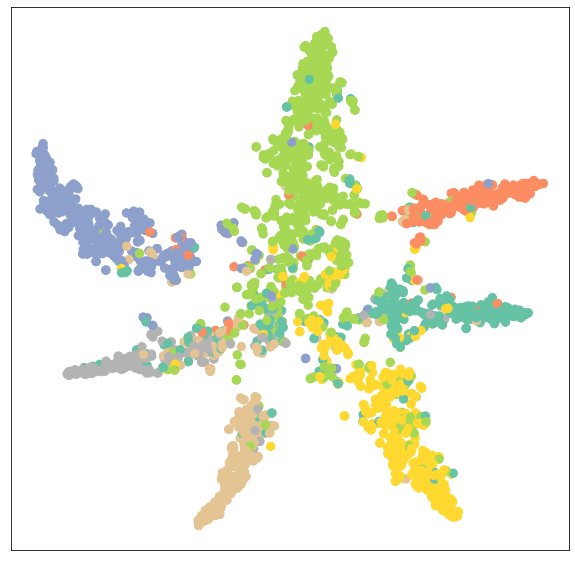

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    # 降维至2个主成份
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# 预测    
model.eval()
out = model(data)
# 绘图
visualize(out.cpu(), color=data.cpu().y)